# Metagenomic Analysis

**Authors:** [Tony Kabilan Okeke](mailto:tko35@drexel.edu), [Ifeanyi Osuchukwu](mailto:imo27@drexel.edu)  
**Date:** 02.28.2022

Identification of the types and abundances of the micobial species living on the human body is important for understanding the interactions of these microorganisms among themselves and with the host. A change or difference in the composition of the microbiome has been implicated in a number of diseases.

In this assignment, you will analyze a (hypothetical) sample from oral cavity and identify the species and abundances of the bacteria. You are given the short reads obtained from Next-Gen sequencing of the sample. The data used for this assignment was extracted/adapted from the publication [*"Next Generation Sequencing Data of a Defined Microbial Mock Community"*](https://www.nature.com/articles/sdata201681)

The data used here has been manipulated and should not be used to draw any scientific conclusions.

To simplify the assignment, you are only asked to find out the fraction of 3 microorganism species.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import simplesam
import bmes
import re
import os
from Bio import SeqIO

%matplotlib inline

In [3]:
# Set up datadir and BWA path
DATADIR = bmes.datadir() + '/hwmetagenome/'
if not bmes.isfolder(DATADIR):
    bmes.mkdirif(DATADIR)

if bmes.computername() == 'KabilansPC':
    BWAEXE = "/home/kabil/.anaconda3/envs/blast/bin/bwa"
else:
    BWAEXE = bmes.bwaexe(); # Ahmet's installation

In [4]:
# Definitions
def download_genome(accesion: str, file: str) -> str:
    if not bmes.isfileandnotempty(DATADIR + file):
        bmes.downloadurl(
            f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nuccore&id={accesion}&rettype=fasta",
            DATADIR + file
        )    
    return (DATADIR + file)

### Download Next-Gen Sequence Data (fastq file)

A small data file is provided so you can develop and test your analysis code quickly. Your final results should be based on the largest data file.

In [5]:
fastqfile = "http://sacan.biomed.drexel.edu/ftp/SRR3656745_pass.randsample.select.102.fastq"

# Uncomment the following lines to test your code on the larger file, 
# once it works for the smaller file above.
#fastqfile = "http://sacan.biomed.drexel.edu/ftp/SRR3656745_pass.randsample.select.1001.fastq"

# Uncomment the following line to test your code on this larger file once it
# works for the smaller file(s) above.
#fastqfile = "http://sacan.biomed.drexel.edu/ftp/SRR3656745_pass.randsample.select.10001.fastq"

# Uncomment the following line to test your code on this larger file, once it
# works for the smaller file(s) above.
# Your final results should be based on this data file.
#fastqfile = "http://sacan.biomed.drexel.edu/ftp/SRR3656745_pass.randsample.select.86588.fastq"

if bool(re.search('^(https?://|ftps?://)', fastqfile)):
    fastqfile = bmes.downloadurl(fastqfile, DATADIR + "randsample.102.fastq")
    #fastqfile = bmes.downloadurl(fastqfile, DATADIR + "randsample.86588.fastq") # Final version

### Download the Genomes

Download the following genomes:
- Olsenella uli (NC_014363.1)
- Segniliparus rotundu (NC_014168.1)
- Escherichia coli K-12 (NC_000913.1)

In [6]:
genomes = {
    "O_uli": download_genome("NC_014363.1", "Olsenella_uli.fasta"),
    "S_rotundu": download_genome("NC_014168.1", "Segniliparus_rotundu.fasta"),
    "E_coli": download_genome("NC_000913.1", "Escherichia_coli.fasta")
}

### Basic Mapping: Map the `FASTQ` file to the Following Three Genomes Separately

Use `BWA` to map the reads to each of the genomes.

Check the result of the BWA to assign each short read to one of the genomes, or assign it "Unknown" if it cannot be mapped to any of the genomes.

- If a short read does not map to any organism, increase the count for the Unknown group by 1.  
Not-aligned short reads have a ReferenceName `'*'` and a Position 0.
- If a short read maps to only one organism, increase the count for that organism by 1.
- If a short read maps to more than one organism, use a fractional increase in the organism counts.  
E.g., if a read is mapped to the first and third organisms only, increase the counts for the first and third organisms by 0.5, and do not increase the count for the second organism.  
E.g., if a read is mapped to all three organisms, increase each of their counts by 1/3.

**Note:** `BWA` may return more than one hit within a genome for a read. You need to make sure such hits are not counted multiple times for a genome.

In [7]:
# Index the reference genomes
for species in genomes:
    if not bmes.isfileandnotempty(genomes[species] + '.bwt'):
        cmd = f"{BWAEXE} index '{genomes[species]}'"
        os.system(cmd)
    else:
        print(f"{species} genome already exists.")

O_uli genome already exists.
S_rotundu genome already exists.
E_coli genome already exists.


In [8]:
# Align sequence to reference genomes
samfiles = dict()

for species in genomes:
    samfiles[species] = f"{DATADIR}{fastqfile.split('/')[-1]}_{genomes[species].split('/')[-1]}.sam"
    if not bmes.isfileandnotempty(samfiles[species]):
        cmd = f"{BWAEXE} mem '{genomes[species]}' '{fastqfile}'"
        bmes.system_redirecttofile(cmd, samfiles[species])

In [9]:
# Parse sam files into data frames
sams = {k:[] for k in genomes}

for species in genomes:
    with open(samfiles[species], 'r') as f:
        samiter = simplesam.Reader(f)
        for sam in samiter:
            sams[species].append(sam)

In [10]:
# Get list of short read names
read_names = [r.id for r in SeqIO.parse(fastqfile, 'fastq')]
# Initialize data frame to count mappings
counts = {species: {k:0 for k in read_names} for species in genomes}

for species in genomes:
    for name in read_names:
        for i in range(len(sams[species])):
            if sams[species][i].qname == name and sams[species][i].pos > 0:
                # +1 if read is mapped to reference genome
                counts[species][name] += 1

# Convert counts to data frame
df = pd.DataFrame.from_dict(counts)
# # Set all counts > 1 to 1 (Avoid counting multiple hits)
df = df.where(df < 1, 1)
# Add Unknown column
df['Unknown'] = (df.sum(axis=1) == 0).astype(int)
# Normalize rows
df = df.div(df.sum(axis=1), axis=0)

df.head()

,O_uli,S_rotundu,E_coli,Unknown
SRR3656745.86422854,0.000000,0.000000,0.000000,1.0
SRR3656745.114534008,0.000000,1.000000,0.000000,0.0
SRR3656745.41048679,0.000000,0.000000,1.000000,0.0
SRR3656745.32989713,0.000000,1.000000,0.000000,0.0
SRR3656745.77742209,0.333333,0.333333,0.333333,0.0


### Results

#### Total Read Counts

Show a bar graph of total read counts assigned to each organism and to the Unknown group. The x axis of the bar graph should show the organisms (including the Unknown group), and the y axis should show the counts of reads mapped to each organism.

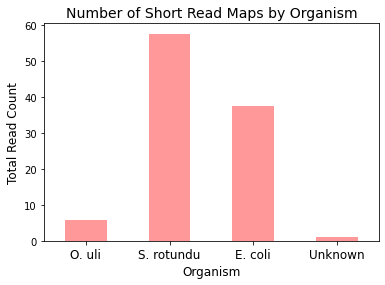

In [17]:
fig = plt.figure(figsize=(6,4))
ax = df.sum().plot.bar(color='red', alpha=.4)
ax.set_xticklabels(['O. uli', 'S. rotundu', 'E. coli', 'Unknown'], fontsize=12, rotation=0)
ax.set_xlabel("Organism", fontsize=12)
ax.set_ylabel("Total Read Count", fontsize=12)
ax.set_title("Number of Short Read Maps by Organism", fontsize=14);

#### Percent Abundances

Show the percent abundances of the species (**excluding** the Unknown group) as a bar graph. Label the bars with the species names. Make sure you normalize the counts of the reads assigned to each organism by the genome size of that organism. The percentages of the three organisms should add up to 100%.

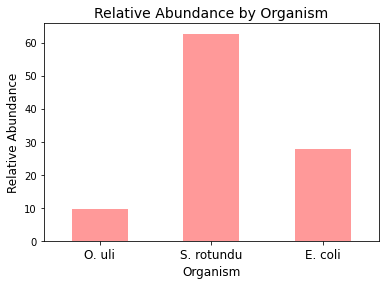

In [19]:
# Normalize the read counts by the respective genome size
relative_abundance = df.iloc[:, :3].sum(axis=0)  # sum of known columns
for g in genomes:
    size = len(list(SeqIO.parse(genomes[g], 'fasta'))[0].seq)
    relative_abundance[g] = relative_abundance[g]/size

# Plot percent abundances
relative_abundance = relative_abundance / relative_abundance.sum() * 100

fig = plt.figure(figsize=(6,4))
ax = relative_abundance.plot.bar(color='red', alpha=.4)
ax.set_xticklabels(['O. uli', 'S. rotundu', 'E. coli'], fontsize=12, rotation=0)
ax.set_xlabel("Organism", fontsize=12)
ax.set_ylabel("Relative Abundance", fontsize=12)
ax.set_title("Relative Abundance by Organism", fontsize=14);